# Missing Values
by Wisam Barkho

This portion of the project was completed using R.

## Summary 

For each year, 2 csv files were imported, one containing attributes about each property and another containing transaction data. After the correlated data was removed, the 2 files were merged which reduces the number of rows from 3 million to 90,275. Furthermore, columns with greater than 50% missing values are exlcuded reducing the number of features from 47 to 29. Finally, using boxplots we detected and removed outliers, reducing the number of rows to 80,204. This data set (for 2016) of 80,204 rows and 26 columns is outputed to csv file. 

In [45]:
#load libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(data.table)
library(repr)
library(lattice)
library(mice)

## Year 2017

### Import the data

Import the properties attributes data for 2017.

**Note:** This next cell takes a long time to load, 3 million rows!

In [46]:
#import file with correlated columns removed

properties.2017 <- read.csv("trimmedCorrelation2017.csv", header = T)
properties.2017 <- properties.2017[-1]
head(properties.2017)

parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
10754147,NA,NA,NA,0,0,NA,NA,NA,NA,...,NA,NA,,NA,9,2016,9,,NA,NA
10759547,NA,NA,NA,0,0,NA,NA,NA,NA,...,NA,NA,,NA,27516,2015,27516,,NA,NA
10843547,NA,NA,NA,0,0,5,NA,NA,NA,...,1959,1,,660680,1434941,2016,774261,,NA,NA
10859147,NA,NA,NA,0,0,3,6,NA,NA,...,1948,1,,580059,1174475,2016,594416,,NA,NA
10879947,NA,NA,NA,0,0,4,NA,NA,NA,...,1947,1,,196751,440101,2016,243350,,NA,NA
10898347,NA,NA,NA,0,0,4,4,NA,NA,...,1943,1,,179072,287634,2016,108562,,NA,NA


In [47]:
dim(properties.2017)

[1] 2985217      47

Import the transaction data for 2017.

In [48]:
#train.2017: containing information about the transcations until October 2017

train.2017 <- read.csv("train_2017.csv", header = T)
head(train.2017)

parcelid,logerror,transactiondate
14297519,0.025594902,2017-01-01
17052889,0.055619087,2017-01-01
14186244,0.005382853,2017-01-01
12177905,-0.103409666,2017-01-01
10887214,0.006940359,2017-01-01
17143294,-0.020526269,2017-01-01


In [49]:
#inner join by parcelid
properties2017.merged <- merge(train.2017, properties.2017, by="parcelid")
head(properties2017.merged)

parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
10711855,-0.007357289,2017-07-07,NA,NA,NA,2,3,NA,8,...,1972,NA,,249655,624139,2016,374484,,NA,6.037113e+13
10711877,0.021066284,2017-08-29,1,NA,NA,2,4,NA,8,...,1972,NA,,253000,660000,2016,407000,,NA,6.037113e+13
10711888,0.077174457,2017-04-04,1,NA,NA,2,4,NA,8,...,1972,NA,,257591,542923,2016,285332,,NA,6.037113e+13
10711910,-0.041237636,2017-03-17,NA,NA,NA,2,3,NA,8,...,1960,NA,,57968,78031,2016,20063,,NA,6.037113e+13
10711923,-0.009496421,2017-03-24,NA,NA,NA,2,4,NA,8,...,1960,NA,,167869,415459,2016,247590,,NA,6.037113e+13
10711945,0.001270756,2017-01-30,1,NA,NA,2,3,NA,8,...,1958,NA,,85298,424414,2016,339116,,NA,6.037113e+13


In [50]:
dim(properties2017.merged)

[1] 77613    49

77,613 rows matches number of rows from `train.2017` table  
49 columns: 47 columns from `properties.2017` table + 2 columns from `train.2017` table

## Remove Features with High Missing Values

From the merged table, we will remove any features that have greater than 40% missing values

In [51]:
properties2017.merged[properties2017.merged==""]  <- NA 

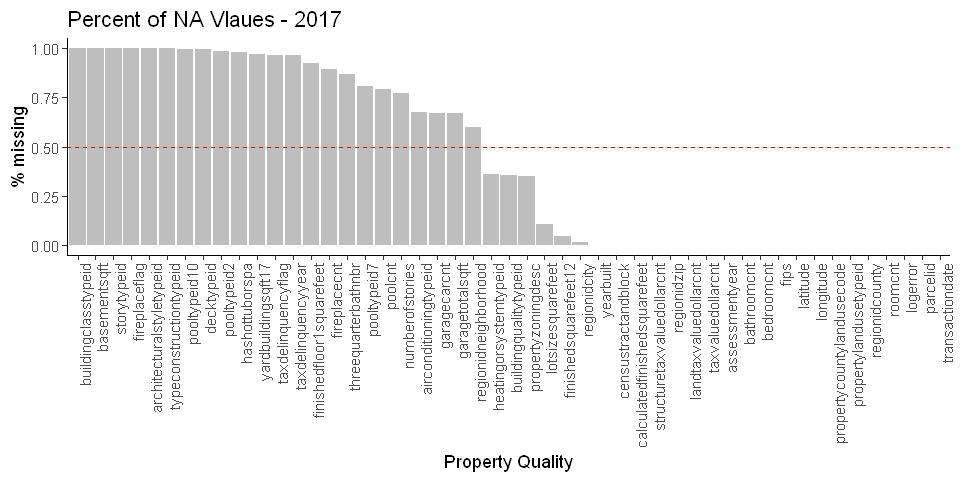

In [52]:
options(repr.plot.width=8, repr.plot.height=4)
NA.aggregated <- properties2017.merged %>% summarize_all(funs(sum(is.na(.))/n()))
NA.aggregated <- gather(NA.aggregated, key="quality", value="precent.NA")
NA.aggregated %>% 
  ggplot(aes(x=reorder(quality,-precent.NA),y=precent.NA)) +
  geom_bar(stat="identity", fill="gray")+
  geom_hline(yintercept=0.5, linetype="dashed", color = "red")+
  labs(title="Percent of NA Vlaues - 2017", x="Property Quality", y="% missing")+
  theme(panel.grid.major = element_blank(),     #removes grid & bg
                  panel.grid.minor = element_blank(), 
                  panel.background = element_blank(), 
                  axis.line = element_line(colour = "black")) +
  theme(axis.text.x=element_text(angle=90, hjust=1))

In [53]:
#make a list of columns that have more than 40% 'NA' values

col_no <- {}
per <- {}

for (i in 1:ncol(properties2017.merged)) {
  x <- sum(is.na(properties2017.merged[i]))/length(properties2017.merged$parcelid)*100
  col_no <- c(col_no, i)
  per <- c(per, x)
}

output <- data.frame(column_no=col_no, percent_na=per)
exclude <- output[output$percent_na > 50,]
t(round(exclude,1))

,4,5,6,9,11,12,16,17,18,19,...,27,33,36,37,38,39,41,42,47,48
column_no,4.0,5.0,6.0,9,11.0,12.0,16.0,17.0,18.0,19,...,27.0,33.0,36.0,37,38.0,39.0,41.0,42.0,47.0,48.0
percent_na,67.8,99.7,99.9,100,99.2,92.2,89.3,67.1,67.1,98,...,80.6,60.1,99.9,87,99.7,96.9,77.3,99.8,96.3,96.3


In [54]:
#report number of features to exclude
length(t(round(exclude[1],1)))

[1] 23

In [55]:
#drop columns that are in exclude list (have more than 50% NA values)
properties2017.trimmed <- properties2017.merged[,-(as.numeric(t(round(exclude[1],1))))]
head(properties2017.trimmed)

parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,heatingorsystemtypeid,...,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,censustractandblock
10711855,-0.007357289,2017-07-07,2,3,8,2107,2107,6037,2,...,12447,3101,96339,0,1972,249655,624139,2016,374484,6.037113e+13
10711877,0.021066284,2017-08-29,2,4,8,1882,1882,6037,2,...,12447,3101,96339,0,1972,253000,660000,2016,407000,6.037113e+13
10711888,0.077174457,2017-04-04,2,4,8,1882,1882,6037,2,...,12447,3101,96339,0,1972,257591,542923,2016,285332,6.037113e+13
10711910,-0.041237636,2017-03-17,2,3,8,1477,1477,6037,2,...,12447,3101,96339,0,1960,57968,78031,2016,20063,6.037113e+13
10711923,-0.009496421,2017-03-24,2,4,8,1918,1918,6037,2,...,12447,3101,96339,0,1960,167869,415459,2016,247590,6.037113e+13
10711945,0.001270756,2017-01-30,2,3,8,2031,2031,6037,2,...,12447,3101,96339,0,1958,85298,424414,2016,339116,6.037113e+13


In [56]:
#report number of rows and features
dim(properties2017.trimmed)

[1] 77613    26

26 columns left: 49 columns from original data minus 23 excluded values  
rows still match number of rows from `train.2017` table

### Detection & Removal of Outliers

histogram of logerror values reveal most values fall in a tight range. using boxplot to identify the outliers and sort function to select out values below -0.1515 and above 0.1665. we will use the values from the 2016 data (the training data) to stay consistenet

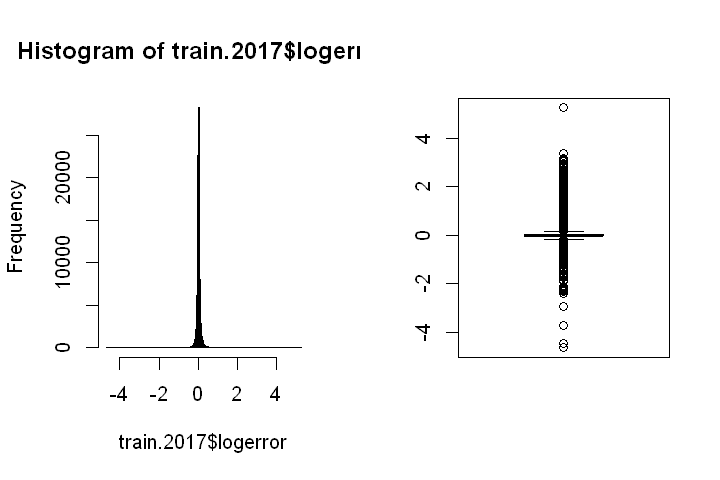

In [57]:
#distribution of logerror values
layout(matrix(1:2, nrow = 1))
options(repr.plot.width=6, repr.plot.height=4)
hist(train.2017$logerror, breaks=200)
le<-boxplot(properties2017.trimmed$logerror, data=properties2017.trimmed, range=2)

In [58]:
sort(le$out)

[1] -4.6554204 -4.4539640 -3.7370185 -2.9229191 -2.4062570 -2.3878002
   [7] -2.3317265 -2.3301621 -2.3274324 -2.3178036 -2.3123947 -2.3114728
  [13] -2.3044702 -2.3001840 -2.2986269 -2.2844063 -2.2841998 -2.2837251
  [19] -2.2835342 -2.2830007 -2.2827294 -2.2714283 -2.2673016 -2.2611234
  [25] -2.2601672 -2.2411260 -2.2381121 -2.2364817 -2.2303459 -2.2118109
  [31] -2.2081110 -2.1927886 -2.1759486 -2.1756962 -2.1348789 -2.1002677
  [37] -1.8974746 -1.8668316 -1.7386392 -1.7023375 -1.6646290 -1.6232531
  [43] -1.5938280 -1.5822696 -1.5012853 -1.4911628 -1.4336751 -1.3704750
  [49] -1.3558094 -1.3415636 -1.3391081 -1.2379976 -1.2017196 -1.1792232
  [55] -1.1728041 -1.1637494 -1.1489845 -1.1419375 -1.1317708 -1.1234378
  [61] -1.1217739 -1.0988141 -1.0930001 -1.0928524 -1.0905406 -1.0891150
  [67] -1.0808340 -1.0781008 -1.0624361 -1.0535878 -1.0413911 -1.0411489
  [73] -1.0370233 -1.0319199 -1.0195608 -1.0165390 -1.0152251 -1.0098383
  [79] -0.9965187 -0.9960171 -0.9895917 -0.9869032 -0.9868640 -0.9850915
  [85] -0.9803942 -0.9760644 -0.9753663 -0.9747424 -0.9653416 -0.9637313
  [91] -0.9612307 -0.9565193 -0.9555322 -0.9512960 -0.9479857 -0.9365886
  [97] -0.9276179 -0.9253528 -0.9246993 -0.9229270 -0.9129239 -0.9040535
 [103] -0.8966049 -0.8897768 -0.8848081 -0.8824839 -0.8812947 -0.8810289
 [109] -0.8740612 -0.8684244 -0.8684154 -0.8666348 -0.8659005 -0.8645643
 [115] -0.8634407 -0.8632127 -0.8607319 -0.8601467 -0.8580557 -0.8530384
 [121] -0.8509776 -0.8495926 -0.8452422 -0.8411830 -0.8408618 -0.8406414
 [127] -0.8398533 -0.8355543 -0.8274731 -0.8272277 -0.8262354 -0.8188472
 [133] -0.8165100 -0.8116277 -0.8110348 -0.8103032 -0.8064461 -0.8000338
 [139] -0.7995140 -0.7956011 -0.7945500 -0.7924790 -0.7895136 -0.7842281
 [145] -0.7779436 -0.7767461 -0.7749917 -0.7733867 -0.7731846 -0.7695076
 [151] -0.7610942 -0.7583805 -0.7555807 -0.7523271 -0.7507813 -0.7491558
 [157] -0.7481248 -0.7468361 -0.7450339 -0.7414901 -0.7404905 -0.7400296
 [163] -0.7358203 -0.7358153 -0.7323277 -0.7306665 -0.7296738 -0.7237600
 [169] -0.7183799 -0.7179668 -0.7177835 -0.7177087 -0.7167796 -0.7160802
 [175] -0.7152194 -0.7054977 -0.7041794 -0.7037047 -0.7007418 -0.6976024
 [181] -0.6962733 -0.6951616 -0.6927976 -0.6909937 -0.6897648 -0.6860878
 [187] -0.6847420 -0.6841208 -0.6828476 -0.6823954 -0.6811722 -0.6787669
 [193] -0.6784152 -0.6739748 -0.6712131 -0.6681622 -0.6665685 -0.6660718
 [199] -0.6652199 -0.6626204 -0.6623611 -0.6613132 -0.6603716 -0.6594789
 [205] -0.6585075 -0.6580807 -0.6553204 -0.6504272 -0.6480919 -0.6451126
 [211] -0.6437470 -0.6432984 -0.6424593 -0.6423422 -0.6423003 -0.6417512
 [217] -0.6372445 -0.6350577 -0.6345319 -0.6300889 -0.6278742 -0.6274743
 [223] -0.6271596 -0.6267912 -0.6248802 -0.6237639 -0.6234900 -0.6230337
 [229] -0.6223846 -0.6201742 -0.6196877 -0.6188568 -0.6184292 -0.6165077
 [235] -0.6138721 -0.6122611 -0.6109148 -0.6091477 -0.6081057 -0.6063994
 [241] -0.6053132 -0.6047969 -0.6039769 -0.6010055 -0.5973282 -0.5966463
 [247] -0.5957595 -0.5953643 -0.5922669 -0.5881791 -0.5881767 -0.5879412
 [253] -0.5846990 -0.5844530 -0.5840355 -0.5839769 -0.5836279 -0.5836174
 [259] -0.5822646 -0.5821875 -0.5806810 -0.5805893 -0.5796402 -0.5732951
 [265] -0.5731966 -0.5721458 -0.5713971 -0.5712543 -0.5710064 -0.5710042
 [271] -0.5660006 -0.5655720 -0.5654957 -0.5647282 -0.5638800 -0.5628454
 [277] -0.5607369 -0.5580499 -0.5578212 -0.5564454 -0.5555123 -0.5554552
 [283] -0.5553013 -0.5549412 -0.5549365 -0.5545238 -0.5511954 -0.5504591
 [289] -0.5495571 -0.5477006 -0.5460009 -0.5453922 -0.5445402 -0.5433178
 [295] -0.5419125 -0.5410677 -0.5406362 -0.5401621 -0.5397467 -0.5389778
 [301] -0.5380371 -0.5373938 -0.5369611 -0.5352702 -0.5343253 -0.5328493
 [307] -0.5314788 -0.5311185 -0.5301722 -0.5299081 -0.5296954 -0.5287510
 [313] -0.5272604 -0.5268141 -0.5263655 -0.5261970 -0.5253675 -0.5253025
 [319] -0.5236473 -0.5210531 -0.5204727 -0.5200226 -0.5195334 -0.5177533
 [325] -0.5172309 -0.5163886 -0.5151808 -0.5149607 -0.5149135

anything greater than 5 bathrooms is considered an outlier

[1]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
 [16]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
 [31]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
 [46]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
 [61]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
 [76]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
 [91]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[106]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[121]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[136]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[151]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[166]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[181]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[196]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5
[211]  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  5.5  6.0
[226]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[241]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[256]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[271]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[286]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[301]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[316]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[331]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[346]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[361]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[376]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[391]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[406]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[421]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[436]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[451]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[466]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[481]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[496]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[511]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[526]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[541]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[556]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[571]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[586]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[601]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[616]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0
[631]  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.5  6.5
[646]  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5
[661]  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5
[676]  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5  6.5
[691]  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0
[706]  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0
[721]  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0  7.0
[736]  7.0  7.0  7.0  7.0  7.0  7

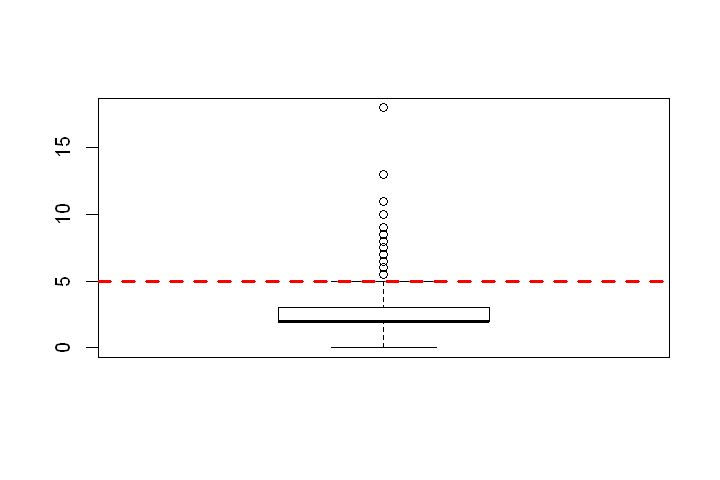

In [59]:
br<-boxplot(properties2017.trimmed$bathroomcnt, data=properties2017.trimmed, range=2)
abline(h=5, col="red", lwd=3, lty=2)
sort(br$out)

anything greater than 8 bedrooms is considered an outlier

[1]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [26]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
 [51]  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10
 [76] 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
[101] 10 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
[126] 12 13 13 14 16

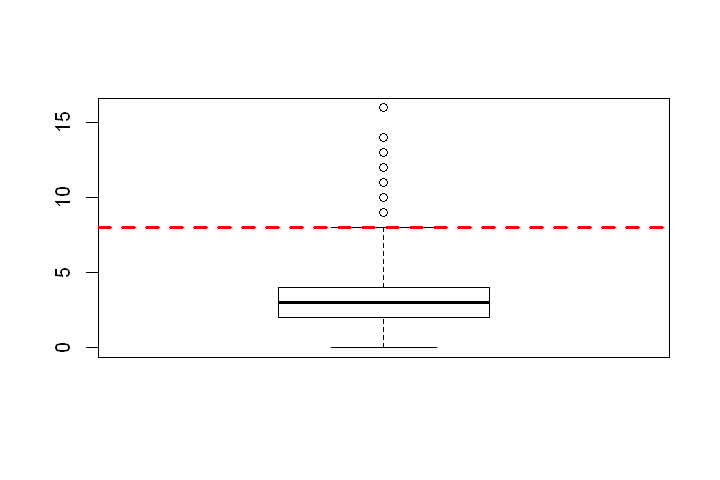

In [60]:
b<-boxplot(properties2017.trimmed$bedroomcnt, data=properties2017.trimmed, range=2)
abline(h=min(b$out-1), col="red", lwd=3, lty=2)
sort(b$out)

although building conditiion 1 is an outlier here, it is not in the 2016 data and therefore will not be considered an outlier. no rows will be removed based on buildingqualitytypeid (condition of the property)

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

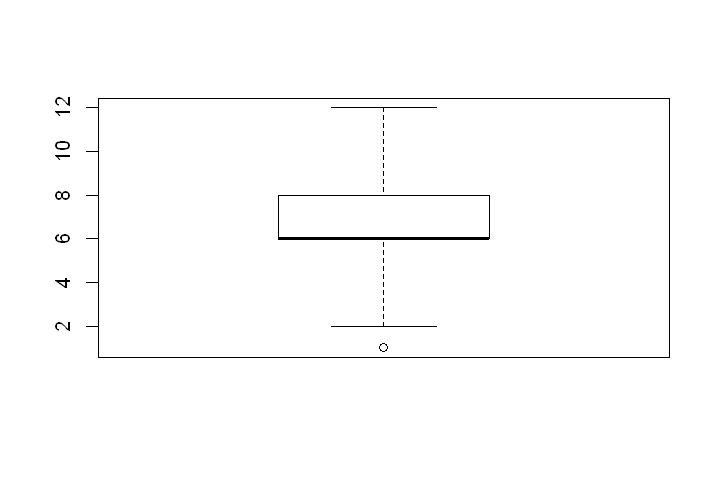

In [61]:
b<-boxplot(properties2017.trimmed$buildingqualitytypeid, data=properties2017.trimmed, range=2)
b$out

anything home greater than 4000 sq feet is considered an outlier

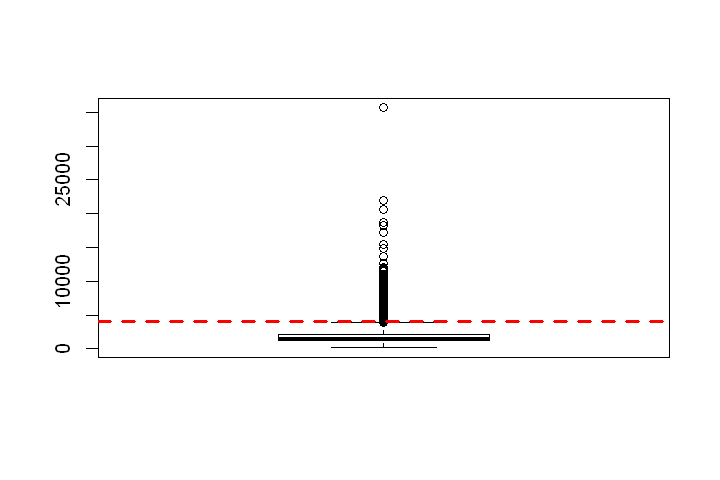

In [62]:
b<-boxplot(properties2017.trimmed$calculatedfinishedsquarefeet, data=properties2017.trimmed, range=2)
abline(h=4000, col="red", lwd=3, lty=2)


although year built prior to 1900 is an outlier here, it is not in the 2016 data and therefore will not be considered an outlier. no rows will be removed based on the year the property was built

[1] 1824 1866 1878 1880 1882 1883

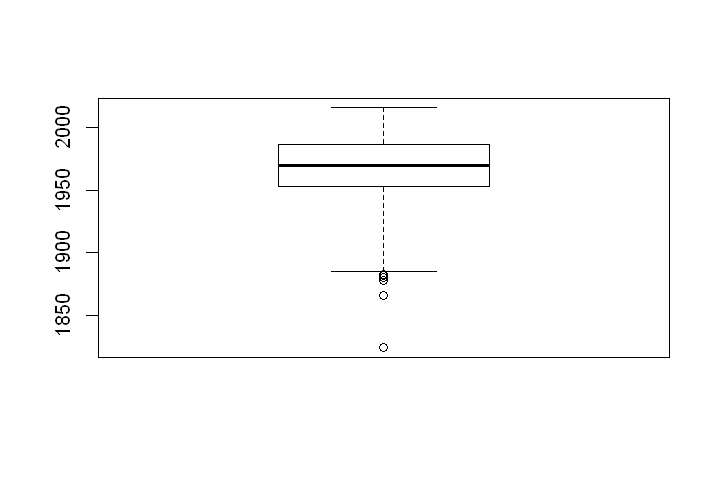

In [63]:
b<-boxplot(properties2017.trimmed$yearbuilt, data=properties2017.trimmed, range=2)
sort(b$out)

since many of these features are related, we will focus on removing rows with extreme values.

In [64]:
newdata <- properties2017.trimmed[properties2017.trimmed$logerror >= -0.1555 & 
                                  properties2017.trimmed$logerror <= 0.1689 &
                                  properties2017.trimmed$bathroomcnt <= 5 &
                                  properties2017.trimmed$bedroomcnt <= 8 &
                                  properties2017.trimmed$calculatedfinishedsquarefeet <= 4000,]
dim(newdata)

[1] 68739    26

outlier data accounts for almost 10,000 rows  
68,739 rows remain  
26 features match the number of features before outlier removal

### Output File

In [65]:
#output to csv file
write.csv(newdata, file = "outlierRemoval2017.csv")